In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import re
#this is a python magic function to automatically show matplotlib plots
%matplotlib inline  
pd.set_option('display.max_columns', None)

In [45]:
mem = pd.read_csv('../data/NSS_GreatCare_Members.csv')
adm = pd.read_csv('../data/NSS_Hospital_Inpatient_Admissions.csv')
pcp = pd.read_csv('../data/NSS_PrimaryCare_Office_Visits.csv', low_memory = False)
adm.head(5)

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Is Emergency Department Visit Parent Encounter,Is Observation Stay Parent Encounter,CMS Admit Type Code,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,DS1|1,DS1|5047W,DS1|NPI|1306890389,DS1|NPI|1417170523,1.417171e+09,1306890389,2013-01-12,2013-01-14,0,0,1.0,1,1,21.0,NaN,NaN,O70.0,First degree perineal laceration during delivery,0,6620.72,250.0
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,0,0,3.0,1,1,21.0,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,1,0,1.0,1,1,21.0,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1407008907,1.407009e+09,1427055839,2012-12-06,2012-12-09,0,0,3.0,1,1,21.0,NaN,NaN,O70.1,Second degree perineal laceration during delivery,0,14800.00,250.0
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,DS1|1,DS1|5047W,DS1|NPI|1992818256,DS1|NPI|1518045608,1.518046e+09,1992818256,2015-03-11,2015-03-14,0,0,2.0,2,1,NaN,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",0,0.00,0.0


two[['First','second','third','fourth','fifth','sixth','Last']] = two['Encounter ID'].apply(
   lambda x: pd.Series(str(x).split("|")))
two.head()

In [3]:
#set datetime
adm['Encounter Start Date'] = pd.to_datetime(adm['Encounter Start Date'], format='%Y-%m-%d')
adm['Encounter End Date'] = pd.to_datetime(adm['Encounter End Date'], format='%Y-%m-%d')
pcp['Encounter Date'] = pd.to_datetime(pcp['Encounter Date'], format='%Y-%m-%d')

# MVP 1 
What is our 30-day all cause readmission rate across hospitals our members are admitted to?

In [4]:
#make df(patient, start date, end date)
one = adm[['Patient ID','Encounter Start Date','Encounter End Date']]
#order by patient then start date
one = one.sort_values(['Patient ID',"Encounter Start Date", "Encounter End Date"], ascending = (False, True, True))
#shift previous end date to next row and math
one['Previous End Date'] = (one.groupby('Patient ID')['Encounter End Date'].shift(1))
one['Days Since Last Visit'] = one['Encounter Start Date'] - one['Previous End Date']

ad_count = len(one)
ad_count

6213

#Different Direction<br>
#if difference between Encounter End Date and Encounter Start Date 
one['diff'] = one.groupby('Patient ID')['Encounter Start Date'].diff() / np.timedelta64(1, 'D')
one['diff'] = one['diff'].fillna(0)
one['diff_end'] = one.groupby('Patient ID')['Encounter End Date'].diff() / np.timedelta64(1, 'D')
one['diff_end'] = one['diff_end'].fillna(0)
#length of stay - not grouped by
one['length'] = one['Encounter End Date']-one['Encounter Start Date'] 
one['length'] = one['length'].fillna(0)

In [54]:
#filter for readmission and within 30 days
one_top = one#[['Patient ID', 'Previous End Date', 'Encounter Start Date', 'Encounter End Date', 'Days Since Last Visit']]
one_top = one_top[one_top['Days Since Last Visit'].notnull()]
one_top = one_top[one_top['Days Since Last Visit'] <= '30 days']
one_top = one_top[one_top['Days Since Last Visit'] >= '0 days']
read_count = len(one_top)
read_count
one_top

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Is Emergency Department Visit Parent Encounter,Is Observation Stay Parent Encounter,CMS Admit Type Code,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Previous End Date,Days Since Last Visit,Year
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1750544516,1.750545e+09,1689608150,2015-11-24,2015-11-27,0,0,2.0,1,1,21.0,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",0,19919.42,250.0,2015-11-23,1 days,2015
6202,HIA|DS1|9943|DS1|NPI|1184722779|2,DS1|9943,DS1|1,DS1|5047X,DS1|NPI|1184722779,DS1|NPI|1942320288,1.942320e+09,1184722779,2013-10-25,2013-10-28,1,0,1.0,1,6,21.0,NaN,NaN,K91.89,Other postprocedural complications and disorde...,0,12277.13,0.0,2013-10-16,9 days,2013
6199,HIA|DS1|9935|DS1|NPI|1902803315|1,DS1|9935,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1972545085,1.972545e+09,1902803315,2011-01-25,2011-01-26,0,0,2.0,4,62,21.0,NaN,NaN,I63.211,Cerebral infarction due to unspecified occlusi...,0,13596.10,250.0,2011-01-24,1 days,2011
6197,HIA|DS1|9935|DS1|NPI|1366401333|1,DS1|9935,DS1|1,DS1|5047X,DS1|NPI|1366401333,DS1|NPI|1790917086,1.790917e+09,1366401333,2011-01-26,2011-02-07,0,0,2.0,D,6,21.0,NaN,NaN,I63.211,Cerebral infarction due to unspecified occlusi...,0,45890.00,250.0,2011-01-26,0 days,2011
6185,HIA|DS1|9809|DS1|NPI|1689608150|2,DS1|9809,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1821297797,1.821298e+09,1689608150,2013-01-20,2013-01-24,0,0,2.0,1,1,21.0,NaN,NaN,I48.0,Paroxysmal atrial fibrillation,0,10721.07,250.0,2013-01-11,9 days,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,HIA|DS1|10451|DS1|NPI|1427055839|2,DS1|10451,DS1|1,DS1|5047X,DS1|NPI|1427055839,DS1|NPI|1073566931,1.073567e+09,1427055839,2013-05-01,2013-05-09,1,0,1.0,1,6,23.0,571.2,Alcoholic cirrhosis of liver,NaN,NaN,0,51700.00,0.0,2013-04-26,5 days,2013
40,HIA|DS1|10451|DS1|NPI|1427055839|4,DS1|10451,DS1|1,DS1|5047X,DS1|NPI|1427055839,DS1|NPI|1679541775,1.679542e+09,1427055839,2013-07-26,2013-08-03,0,0,1.0,1,6,21.0,571.2,Alcoholic cirrhosis of liver,NaN,NaN,0,59395.00,0.0,2013-07-01,25 days,2013
41,HIA|DS1|10451|DS1|NPI|1427055839|5,DS1|10451,DS1|1,DS1|5047X,DS1|NPI|1427055839,DS1|NPI|1215189550,1.215190e+09,1427055839,2013-08-31,2013-09-02,0,0,3.0,2,1,21.0,571.2,Alcoholic cirrhosis of liver,NaN,NaN,0,27653.05,0.0,2013-08-03,28 days,2013
43,HIA|DS1|10451|DS1|NPI|1427055839|7,DS1|10451,DS1|1,DS1|5047X,DS1|NPI|1427055839,DS1|NPI|1053358127,1.053358e+09,1427055839,2013-12-17,2013-12-19,0,0,1.0,1,1,21.0,NaN,NaN,R55,Syncope and collapse,0,10650.00,250.0,2013-11-20,27 days,2013


In [6]:
#find the readmission rate
read_rate = round(read_count/ad_count *100,2)
read_rate

11.31

In [7]:
#find the unique readmission rate 
read_rate_unique = round(one_top['Patient ID'].nunique() / one['Patient ID'].nunique()*100,2)
read_rate_unique

9.47

# Visualize it


In [138]:
# de-filtered dfs (above)
# new variables
one_top['year'] = pd.DatetimeIndex(one_top['Encounter Start Date']).year
p_count = one_top.groupby(['Patient ID'], as_index=False).count()
p_high = p_count[p_count['Encounter ID'] > 0]

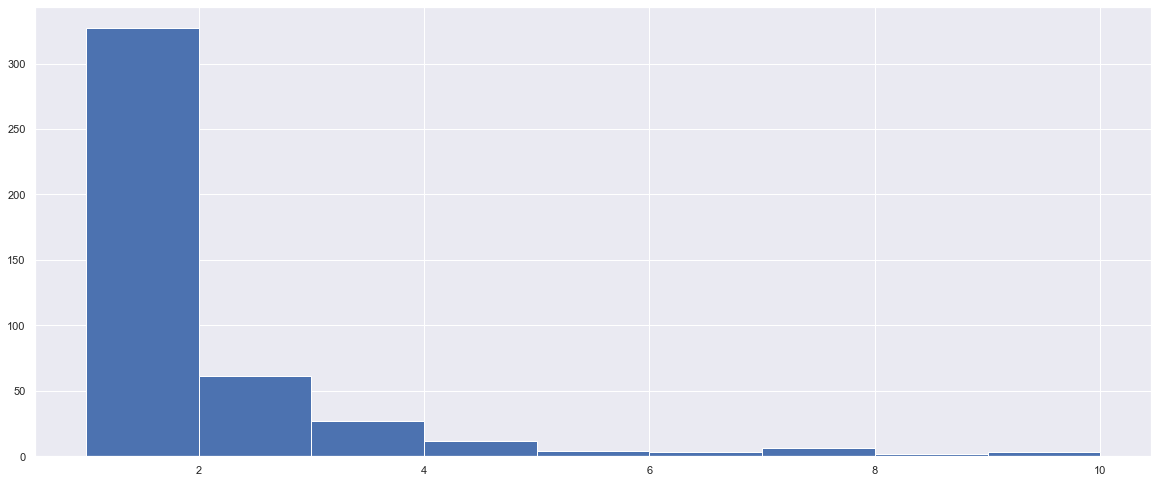

In [139]:
plt.hist('Encounter ID', bins = 9, data = p_high);

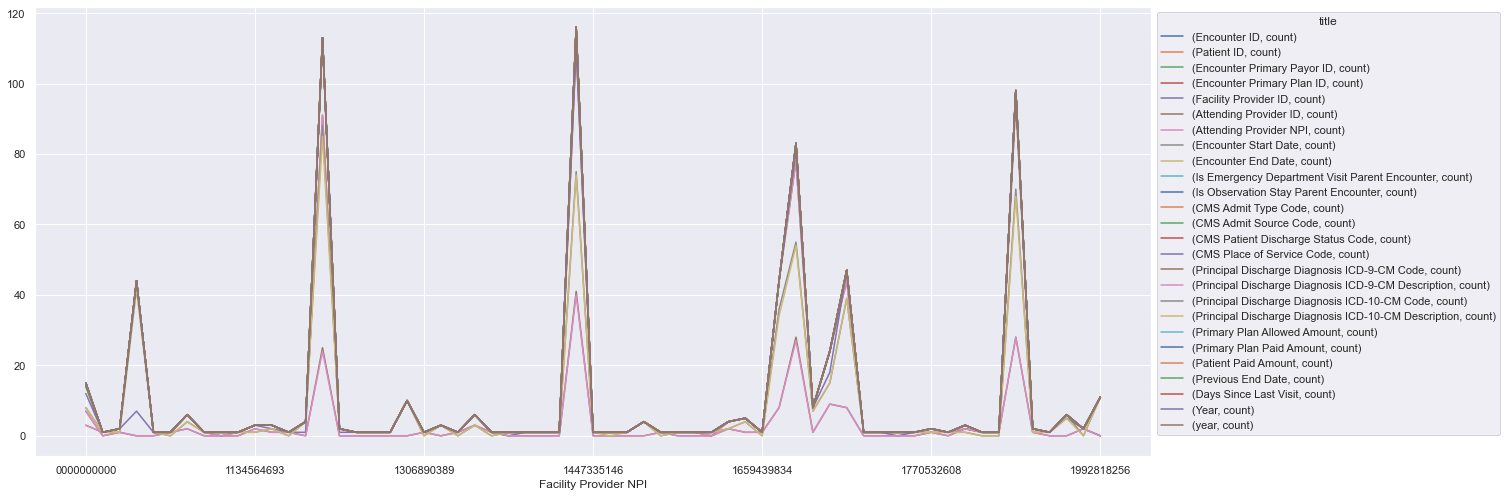

In [140]:
#line
line = one_top.groupby(['Facility Provider NPI'], as_index=False).agg(['count'])
line.plot()
plt.legend(title='title', bbox_to_anchor=(1, 1), loc='upper left')

In [ ]:
#pairplot 
pair = one_top.groupby(['Facility Provider NPI'], as_index=False)
sns.set(style="ticks", color_codes=True)
sns.pairplot(pair);

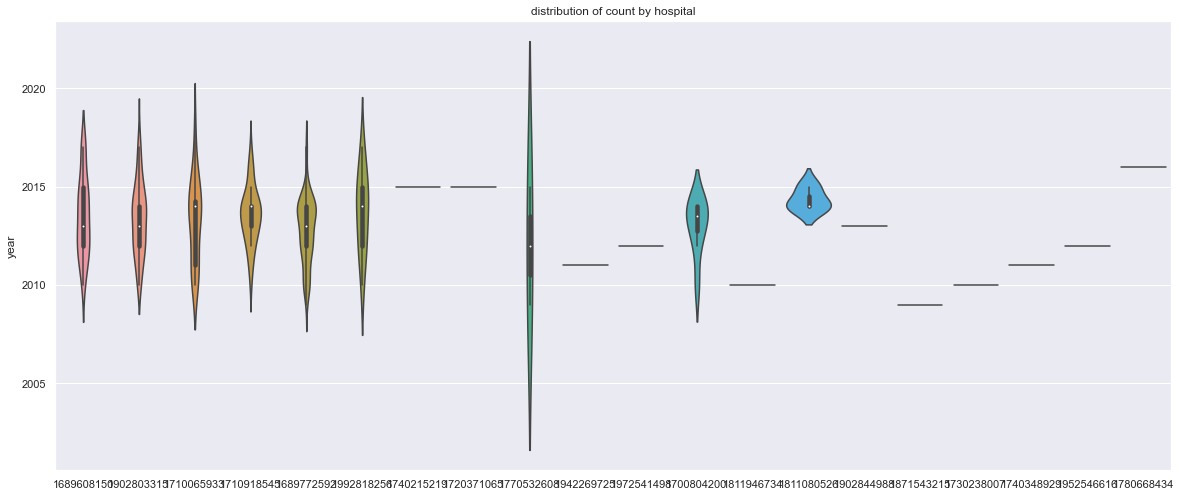

In [143]:
sns.set(rc={'figure.figsize':(20,8.27)})
violin = one_top[one_top['Facility Provider NPI'] >= '1689608150']
sns.violinplot(y=violin['year'], x = violin['Facility Provider NPI'])
plt.title('distribution of count by hospital')
plt.xlabel('');

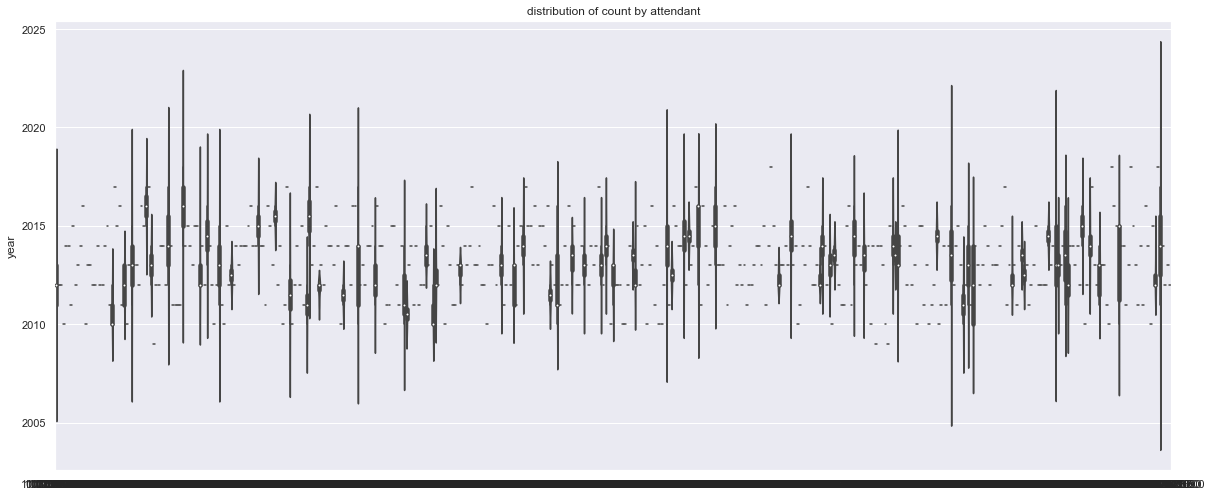

In [144]:
sns.violinplot(y=one_top['year'], x = one_top['Attending Provider NPI'])
plt.title('distribution of count by attendant')
plt.xlabel('');

# MVP 2
What percent of patients have a PCP visit within a week of discharge?

In [8]:
#make df and merge
ad_cut = adm[['Patient ID','Encounter End Date']]
pcp_cut = pcp[['Patient ID','Encounter Date']]
two = ad_cut.merge(pcp_cut, left_on ='Patient ID', right_on = 'Patient ID',how='left', indicator = False)
#sub encounter date from end dates
two['Days Since Last Visit'] = two['Encounter Date'] - two['Encounter End Date']
two_top = two[two['Days Since Last Visit'] <= '7 days']
two_top = two_top[two_top['Days Since Last Visit'] >= '0 days']
#count
count_two_top = len(two_top)
two_top

,Patient ID,Encounter End Date,Encounter Date,Days Since Last Visit
17,DS1|10043,2014-01-12,2014-01-12,0 days
28,DS1|10073,2012-06-21,2012-06-27,6 days
50,DS1|10101,2012-12-09,2012-12-12,3 days
231,DS1|10303,2012-06-24,2012-06-30,6 days
238,DS1|10303,2012-06-24,2012-06-28,4 days
...,...,...,...,...
44051,DS1|9945,2013-02-11,2013-02-14,3 days
44067,DS1|9978,2015-09-05,2015-09-11,6 days
44071,DS1|9979,2015-02-11,2015-02-15,4 days
44074,DS1|9981,2014-08-10,2014-08-11,1 days


In [9]:
#find the pcp visit within 7 days rate
pcp_visit_rate = round(count_two_top/ad_count *100,2)
pcp_visit_rate

38.23

# Question 3
Do either vary by individual or group PCP's?